# 📊 Projeto Aplicado II – EDA + Modelo Preditivo (Serasa)

Este notebook executa todo o pipeline:

✔️ Carrega o dataset estruturado `serasa.csv`
✔️ Realiza EDA completa
✔️ Gera gráficos (linhas, histogramas, boxplot, pizza)
✔️ Gera Tabela 1 (Inadimplentes)
✔️ Treina modelo preditivo de VTDD
✔️ Gera Tabela 2 (histórico + previsão)
✔️ Plota o gráfico final de previsão

---
## 📂 Estrutura esperada
- `datasets/serasa.csv`
- `figures/` será criado automaticamente

---

In [27]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix

Carregar o dataset

In [9]:
# Configuração de caminhos em Notebook
BASE_DIR = Path().resolve()
DATA_PATH = "https://raw.githubusercontent.com/GrupoMackenzie/ProjetoAplicado02-DataScience-Mackenzie-2025/master/datasets/serasa.csv"
FIG_DIR = BASE_DIR / "figures"
FIG_DIR.mkdir(exist_ok=True, parents=True)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

MESES_FULL = {
    "jan": "Janeiro", "fev": "Fevereiro", "mar": "Março",
    "abr": "Abril", "mai": "Maio", "jun": "Junho",
    "jul": "Julho", "ago": "Agosto", "set": "Setembro",
    "out": "Outubro", "nov": "Novembro", "dez": "Dezembro"
}

def periodo_sort_key(p):
    if not isinstance(p, str) or "/" not in p:
        return (9999, 99)
    mes, yy = p.split("/")
    mapa = {
        "jan": 1, "fev": 2, "mar": 3, "abr": 4,
        "mai": 5, "jun": 6, "jul": 7, "ago": 8,
        "set": 9, "out": 10, "nov": 11, "dez": 12,
    }
    m = mapa.get(mes.lower(), 99)
    try:
        y = 2000 + int(yy)
    except:
        y = 9999
    return (y, m)

def periodo_full_label(p):
    if not isinstance(p, str) or "/" not in p:
        return p
    mes_abbr, yy = p.split("/")
    mes_nome = MESES_FULL.get(mes_abbr.lower(), mes_abbr)
    ano = 2000 + int(yy)
    return f"{mes_nome} {ano}"

## 📥 1. Carregamento e tratamento inicial

In [10]:
def load_data():
    df = pd.read_csv(DATA_PATH)

    num_cols = [
        "INADIMPLENTES_MI", "VMPP", "DIVIDAS_MI",
        "VMCD", "VTDD_BI", "VMAF", "DESCONTOS_BI",
    ]
    for c in num_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.sort_values("PERIODO", key=lambda s: s.map(periodo_sort_key)).reset_index(drop=True)
    df["t"] = np.arange(len(df))
    df["PERIODO_FULL"] = df["PERIODO"].apply(periodo_full_label)

    return df

df = load_data()
df

,PERIODO,INADIMPLENTES_MI,VMPP,DIVIDAS_MI,VMCD,VTDD_BI,VMAF,DESCONTOS_BI,t,PERIODO_FULL
0,out/24,73.10,5504.33,276.08,1457.48,402.03,734.83,10.51,0,Outubro 2024
1,nov/24,73.79,5558.30,274.54,1493.92,410.14,590.74,15.60,1,Novembro 2024
2,dez/24,73.51,5496.69,275.68,1465.73,404.07,560.00,13.40,2,Dezembro 2024
3,jan/25,74.60,5617.00,281.25,1489.90,419.00,676.00,10.20,3,Janeiro 2025
4,fev/25,75.00,5837.49,286.11,1530.28,437.00,698.00,12.10,4,Fevereiro 2025
5,mar/25,75.70,5793.66,287.60,1526.41,438.00,714.00,17.70,5,Março 2025
6,abr/25,76.60,5968.71,294.10,1555.33,457.00,790.00,10.50,6,Abril 2025
7,mai/25,77.00,6036.94,298.50,1558.68,465.00,839.00,11.70,7,Maio 2025
8,jun/25,77.80,6128.26,304.50,1567.05,477.00,772.00,9.90,8,Junho 2025
9,jul/25,78.20,6177.74,307.50,1570.17,482.00,736.00,11.11,9,Julho 2025


## 📊 2. Estatísticas descritivas e correlações

,PERIODO,INADIMPLENTES_MI,VMPP,DIVIDAS_MI,VMCD,VTDD_BI,VMAF,DESCONTOS_BI,t,PERIODO_FULL
count,12,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12
unique,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
top,out/24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outubro 2024
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
mean,NaN,76.100000,5888.469167,292.655000,1531.475000,448.436667,723.297500,12.301667,5.500000,NaN
std,NaN,2.117335,295.124550,14.504754,44.757391,34.802269,83.506992,2.335111,3.605551,NaN
min,NaN,73.100000,5496.690000,274.540000,1457.480000,402.030000,560.000000,9.900000,0.000000,NaN
25%,NaN,74.397500,5602.325000,279.957500,1492.915000,416.785000,692.500000,10.507500,2.750000,NaN
50%,NaN,76.150000,5903.100000,290.850000,1542.805000,447.500000,735.415000,11.900000,5.500000,NaN
75%,NaN,77.900000,6140.630000,305.250000,1567.830000,478.250000,776.500000,12.950000,8.250000,NaN



Foco VTDD e INADIMPLENTES:



,VTDD_BI,INADIMPLENTES_MI
count,12.000000,12.000000
mean,448.436667,76.100000
std,34.802269,2.117335
min,402.030000,73.100000
25%,416.785000,74.397500
50%,447.500000,76.150000
75%,478.250000,77.900000
max,496.000000,79.100000


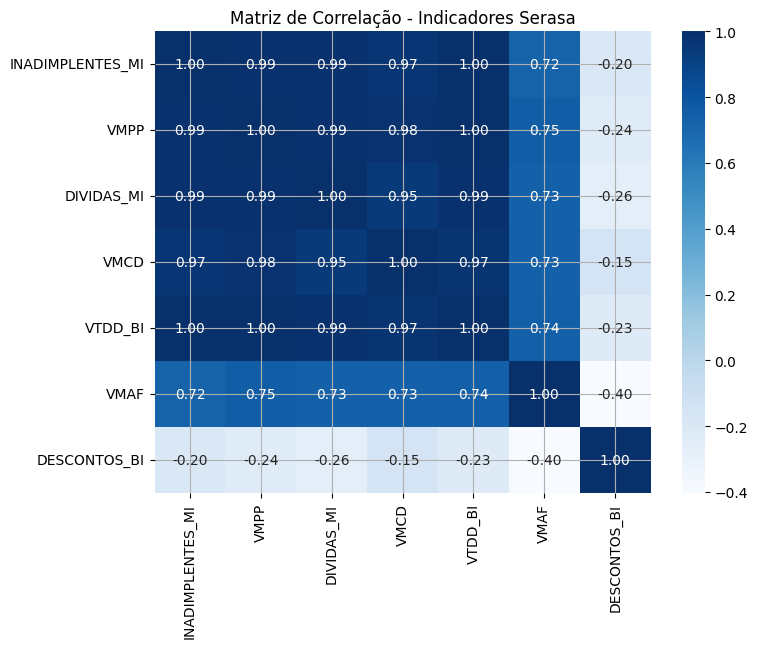

,INADIMPLENTES_MI,VMPP,DIVIDAS_MI,VMCD,VTDD_BI,VMAF,DESCONTOS_BI
INADIMPLENTES_MI,1.000000,0.989696,0.992007,0.967203,0.996146,0.720384,-0.201356
VMPP,0.989696,1.000000,0.989672,0.979432,0.998183,0.749769,-0.237514
DIVIDAS_MI,0.992007,0.989672,1.000000,0.945242,0.994065,0.732719,-0.260133
VMCD,0.967203,0.979432,0.945242,1.000000,0.974797,0.733307,-0.154066
VTDD_BI,0.996146,0.998183,0.994065,0.974797,1.000000,0.738994,-0.227693
VMAF,0.720384,0.749769,0.732719,0.733307,0.738994,1.000000,-0.404391
DESCONTOS_BI,-0.201356,-0.237514,-0.260133,-0.154066,-0.227693,-0.404391,1.000000


In [11]:
def eda_basic_stats(df):
    display(df.describe(include="all"))
    print("\nFoco VTDD e INADIMPLENTES:\n")
    display(df[["VTDD_BI", "INADIMPLENTES_MI"]].describe())

def eda_correlations(df):
    corr = df[[
        "INADIMPLENTES_MI", "VMPP", "DIVIDAS_MI",
        "VMCD", "VTDD_BI", "VMAF", "DESCONTOS_BI"
    ]].corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f")
    plt.title("Matriz de Correlação - Indicadores Serasa")
    plt.show()

    return corr

eda_basic_stats(df)
corr = eda_correlations(df)
corr

## 📈 3. Séries Temporais (Figuras principais)
Inclui:
- Inadimplentes
- VMPP
- DIVIDAS_MI
- VMCD
- VTDD_BI

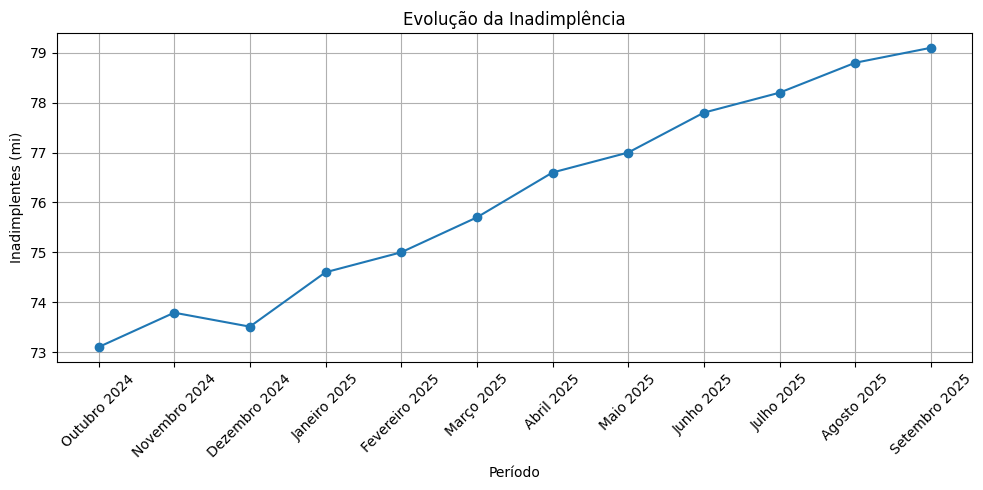

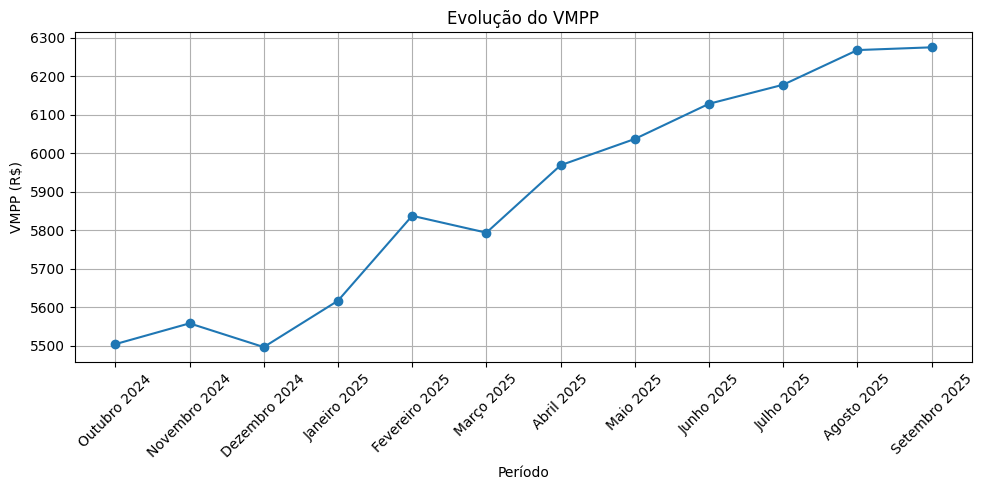

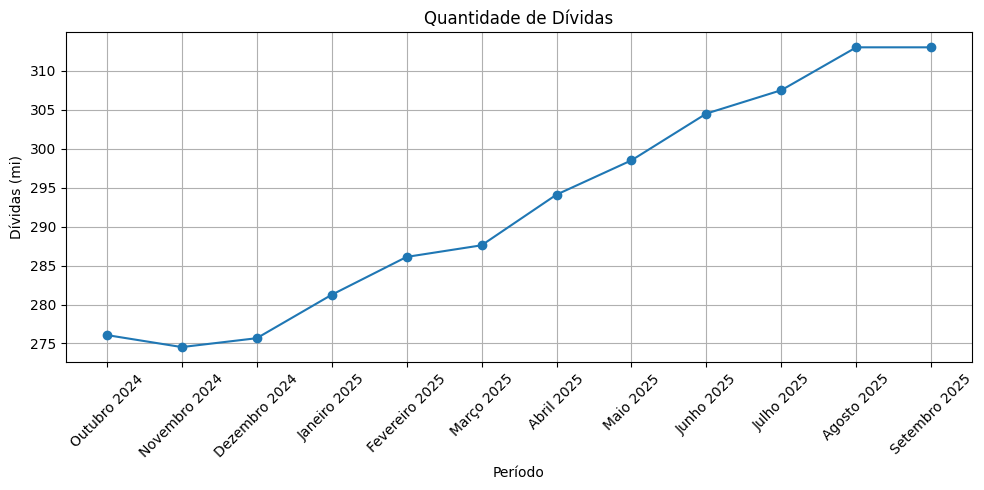

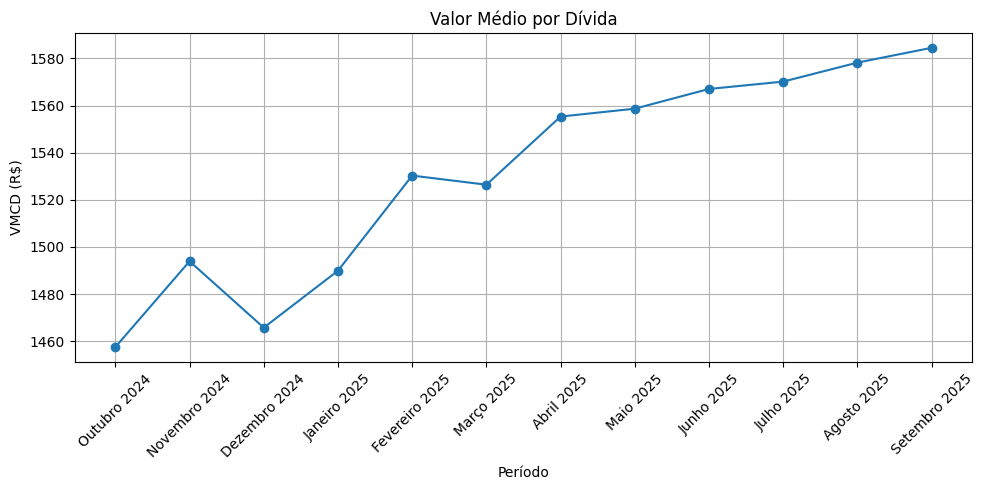

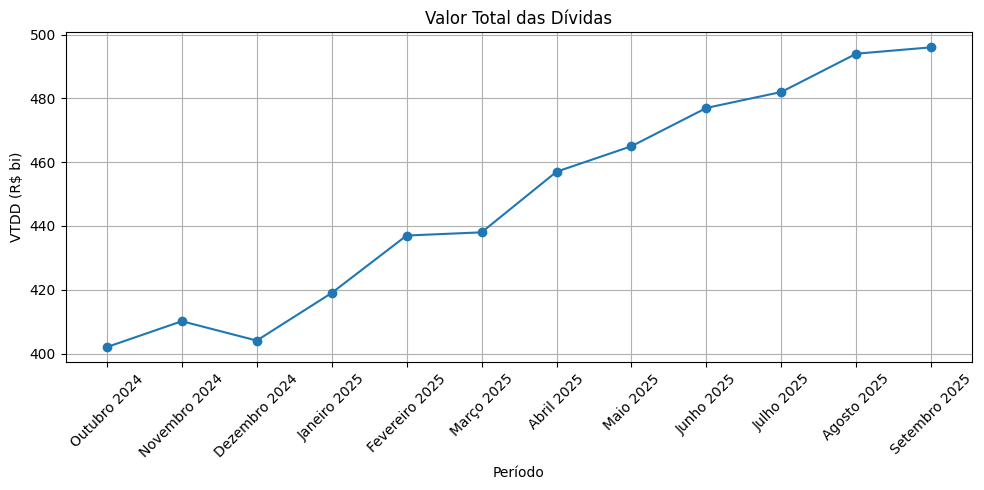

In [12]:
def plot_ts(col, ylabel, title, filename):
    plt.figure()
    plt.plot(df["PERIODO_FULL"], df[col], marker="o")
    plt.xticks(rotation=45)
    plt.xlabel("Período")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(FIG_DIR / filename)
    plt.show()

plot_ts("INADIMPLENTES_MI", "Inadimplentes (mi)", "Evolução da Inadimplência", "ts_inad.png")
plot_ts("VMPP", "VMPP (R$)", "Evolução do VMPP", "ts_vmpp.png")
plot_ts("DIVIDAS_MI", "Dívidas (mi)", "Quantidade de Dívidas", "ts_dividas.png")
plot_ts("VMCD", "VMCD (R$)", "Valor Médio por Dívida", "ts_vmcd.png")
plot_ts("VTDD_BI", "VTDD (R$ bi)", "Valor Total das Dívidas", "ts_vtdd.png")

## 📦 4. Histogramas, Boxplots e Gráfico de Pizza
Inclui tabela de inadimplentes.

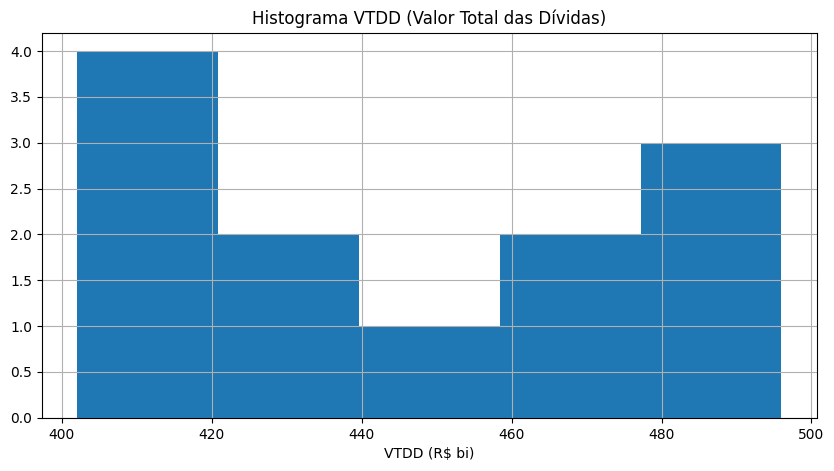

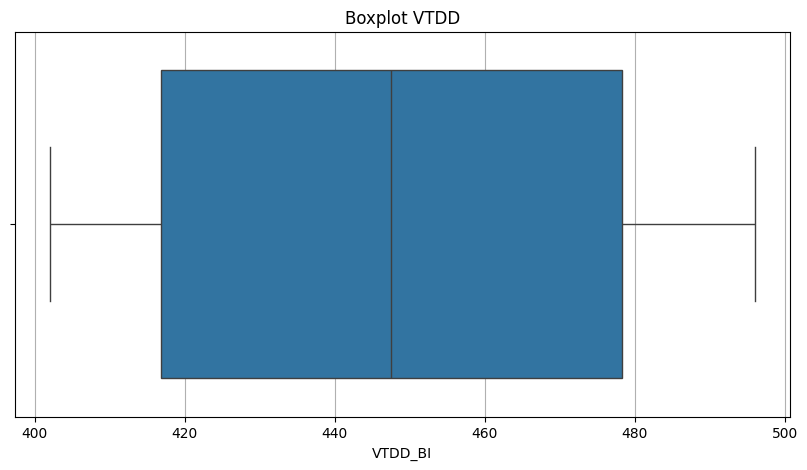

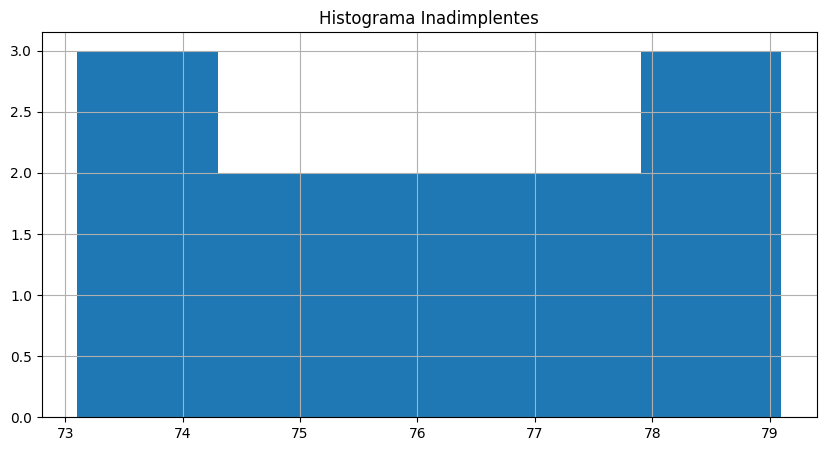

,Mês,Ano,% Total,Qtd (mi)
0,Outubro,2024,8.00,73.10
1,Novembro,2024,8.08,73.79
2,Dezembro,2024,8.05,73.51
3,Janeiro,2025,8.17,74.60
4,Fevereiro,2025,8.21,75.00
5,Março,2025,8.29,75.70
6,Abril,2025,8.39,76.60
7,Maio,2025,8.43,77.00
8,Junho,2025,8.52,77.80
9,Julho,2025,8.56,78.20


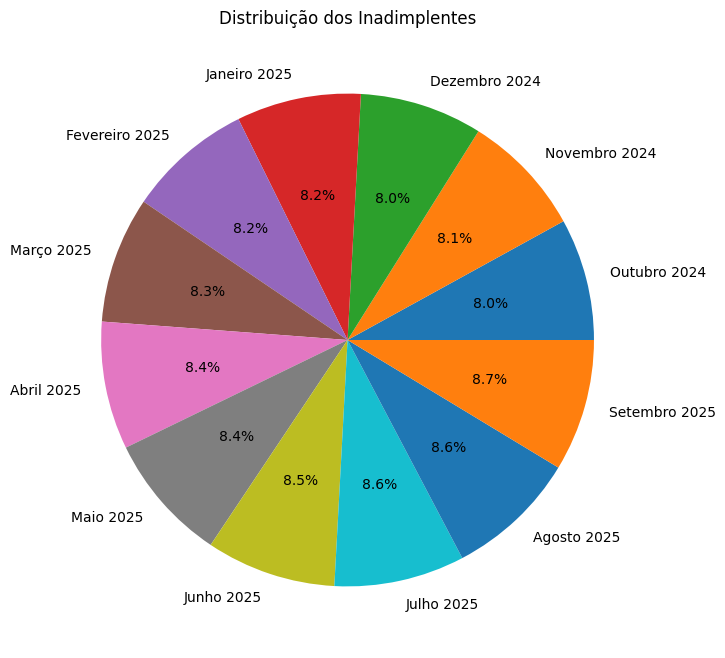

In [13]:
def plot_histograms_boxplots(df):
    plt.hist(df["VTDD_BI"], bins=5)
    plt.title("Histograma VTDD (Valor Total das Dívidas)")
    plt.xlabel("VTDD (R$ bi)")
    plt.show()

    plt.figure()
    sns.boxplot(x=df["VTDD_BI"])
    plt.title("Boxplot VTDD")
    plt.show()

    plt.hist(df["INADIMPLENTES_MI"], bins=5)
    plt.title("Histograma Inadimplentes")
    plt.show()

plot_histograms_boxplots(df)

def build_inadimplentes_table(df):
    total = df["INADIMPLENTES_MI"].sum()
    linhas = []

    for _, row in df.iterrows():
        per = row["PERIODO"]
        mes, yy = per.split("/")
        nome = MESES_FULL[mes]
        ano = 2000 + int(yy)
        pct = 100 * row["INADIMPLENTES_MI"] / total
        linhas.append({
            "Mês": nome,
            "Ano": ano,
            "% Total": round(pct, 2),
            "Qtd (mi)": row["INADIMPLENTES_MI"]
        })

    tab = pd.DataFrame(linhas)
    display(tab)
    return tab

tab_inad = build_inadimplentes_table(df)

def plot_inadimplentes_pie(df):
    plt.figure(figsize=(8, 8))
    plt.pie(df["INADIMPLENTES_MI"], labels=df["PERIODO_FULL"], autopct="%1.1f%%")
    plt.title("Distribuição dos Inadimplentes")
    plt.show()

plot_inadimplentes_pie(df)

## 🤖 5. Modelo Preditivo (Regressão Linear) + Tabela 2 + Forecast Final

In [35]:
def train_vtdd_model(df):

    df = df.sort_values("t").reset_index(drop=True)

    X = df[["t"]].values
    y = df["VTDD_BI"].values

    n = len(df)
    n_train = int(n * 0.7)

    X_train, X_test = X[:n_train], X[n_train:]
    y_train, y_test = y[:n_train], y[n_train:]

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred_test = model.predict(X_test)

    r2 = r2_score(y_test, y_pred_test)
    rmse = mean_squared_error(y_test, y_pred_test)**0.5

    print(f"R² teste: {r2:.4f}")
    print(f"RMSE teste (R$ bi): {rmse:.2f}")

    # previsão histórica
    y_pred_hist = model.predict(X)

    # previsões futuras
    model_full = LinearRegression()
    model_full.fit(X, y)
    last = df["t"].iloc[-1]
    future = np.arange(last+1, last+4).reshape(-1, 1)
    future_pred = model_full.predict(future)

    tabela2 = pd.DataFrame({
        "PERIODO": list(df["PERIODO"]) + ["out/25","nov/25","dez/25"],
        "VTDD_REAL": list(df["VTDD_BI"]) + [np.nan]*3,
        "VTDD_PRED": list(y_pred_hist) + [np.nan]*3,
        "VTDD_PREVISTA": [np.nan]*len(df) + list(future_pred)
    })

    display(tabela2)

    return tabela2, future_pred

tabela2, future_pred = train_vtdd_model(df)

R² teste: 0.7728
RMSE teste (R$ bi): 3.80


,PERIODO,VTDD_REAL,VTDD_PRED,VTDD_PREVISTA
0,out/24,402.03,395.910000,NaN
1,nov/24,410.14,405.372857,NaN
2,dez/24,404.07,414.835714,NaN
3,jan/25,419.00,424.298571,NaN
4,fev/25,437.00,433.761429,NaN
5,mar/25,438.00,443.224286,NaN
6,abr/25,457.00,452.687143,NaN
7,mai/25,465.00,462.150000,NaN
8,jun/25,477.00,471.612857,NaN
9,jul/25,482.00,481.075714,NaN


## 📈 6. Gráfico Final de Previsão (Histórico + 5 meses futuros)

In [ ]:
def plot_forecast(df, future_pred):

    x_hist = df["PERIODO"].tolist()
    x_future = ["ago/25","set/25","out/25","nov/25","dez/25"]

    y_hist = df["VTDD_BI"].values
    y_future = future_pred

    labels_hist = [periodo_full_label(p) for p in x_hist]
    labels_future = [periodo_full_label(p) for p in x_future]
    labels_all = labels_hist + labels_future

    x_hist_idx = np.arange(len(x_hist))
    x_future_idx = np.arange(len(x_hist), len(x_hist)+5)

    plt.figure(figsize=(12,4))
    plt.plot(x_hist_idx, y_hist, marker="o", label="Histórico")
    plt.plot(x_future_idx, y_future, marker="o", linestyle="--", label="Previsão")

    plt.xticks(np.arange(len(labels_all)), labels_all, rotation=45)
    plt.ylabel("VTDD (R$ bi)")
    plt.title("Previsão de Dívidas – Próximos 5 meses")
    plt.legend()

    for x, y in zip(x_hist_idx, y_hist):
        plt.text(x, y+2, f"{round(y)}B", ha="center", fontsize=8)

    for x, y in zip(x_future_idx, y_future):
        plt.text(x, y+2, f"{round(y)}B", ha="center", fontsize=8)

    plt.tight_layout()
    plt.show()

plot_forecast(df, future_pred)